In [1]:
#Step 1: Data Cleaning and Preprocessing

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# Load the data
df = pd.read_csv('/content/f1_pitstops_2018_2024.csv')

# Initial data exploration
print(df.head())
print(df.info())
print(df.describe())

   Season  Round                         Circuit                Driver  \
0    2018      1  Albert Park Grand Prix Circuit      Sebastian Vettel   
1    2018      1  Albert Park Grand Prix Circuit      Sebastian Vettel   
2    2018      1  Albert Park Grand Prix Circuit        Lewis Hamilton   
3    2018      1  Albert Park Grand Prix Circuit        Lewis Hamilton   
4    2018      1  Albert Park Grand Prix Circuit  Kimi RÃƒÂ¤ikkÃƒÂ¶nen   

  Constructor  Laps  Position  TotalPitStops  AvgPitStopTime  \
0     Ferrari    58         1              1          21.787   
1     Ferrari    58         1              1          21.787   
2    Mercedes    58         2              1          21.821   
3    Mercedes    58         2              1          21.821   
4     Ferrari    58         3              1          21.421   

               Race Name  ... Tire Usage Aggression Fast Lap Attempts  \
0  Australian Grand Prix  ...              0.017241          44.76882   
1  Australian Grand Prix

Data cleaning

In [5]:
# Clean driver names
df['Driver'] = df['Driver'].str.replace('ÃƒÂ¤', 'ä').str.replace('ÃƒÂ¶', 'ö').str.replace('ÃƒÂ¼', 'ü').str.replace('ÃƒÂ©', 'é')

# Handle missing values
df.ffill(inplace=True)
df.dropna(inplace=True)

# Convert date to datetime
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')

# Extract year from date
df['Year'] = df['Date'].dt.year

# Drop irrelevant columns
df.drop(['Race Name', 'Time_of_race', 'Location', 'Country', 'Final Stint'], axis=1, inplace=True, errors='ignore')

# Check for duplicates
df.drop_duplicates(inplace=True)

Step 2: Feature Engineering and Visualization

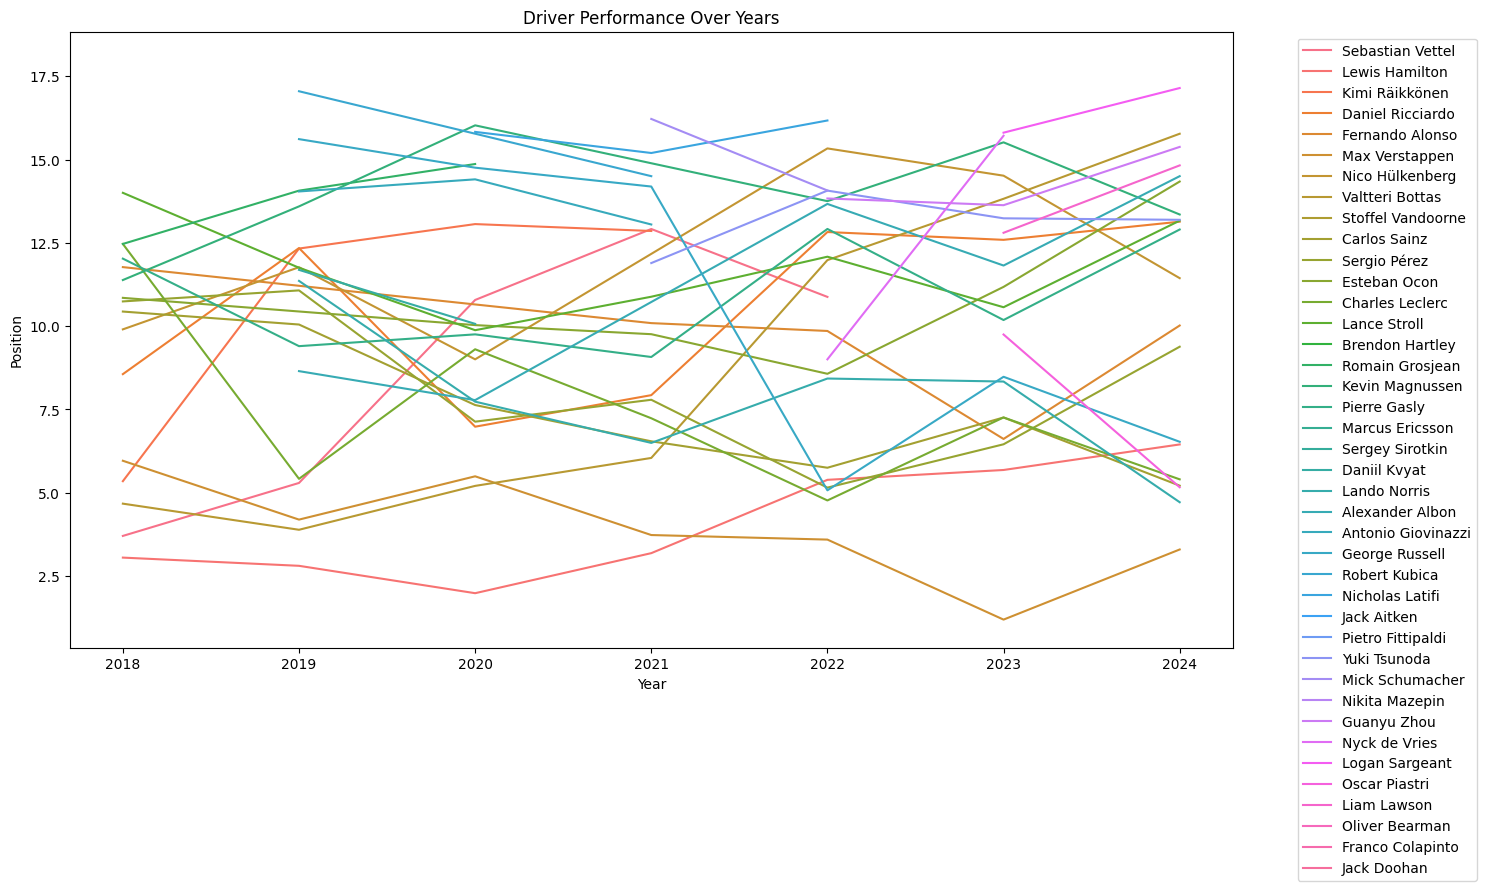

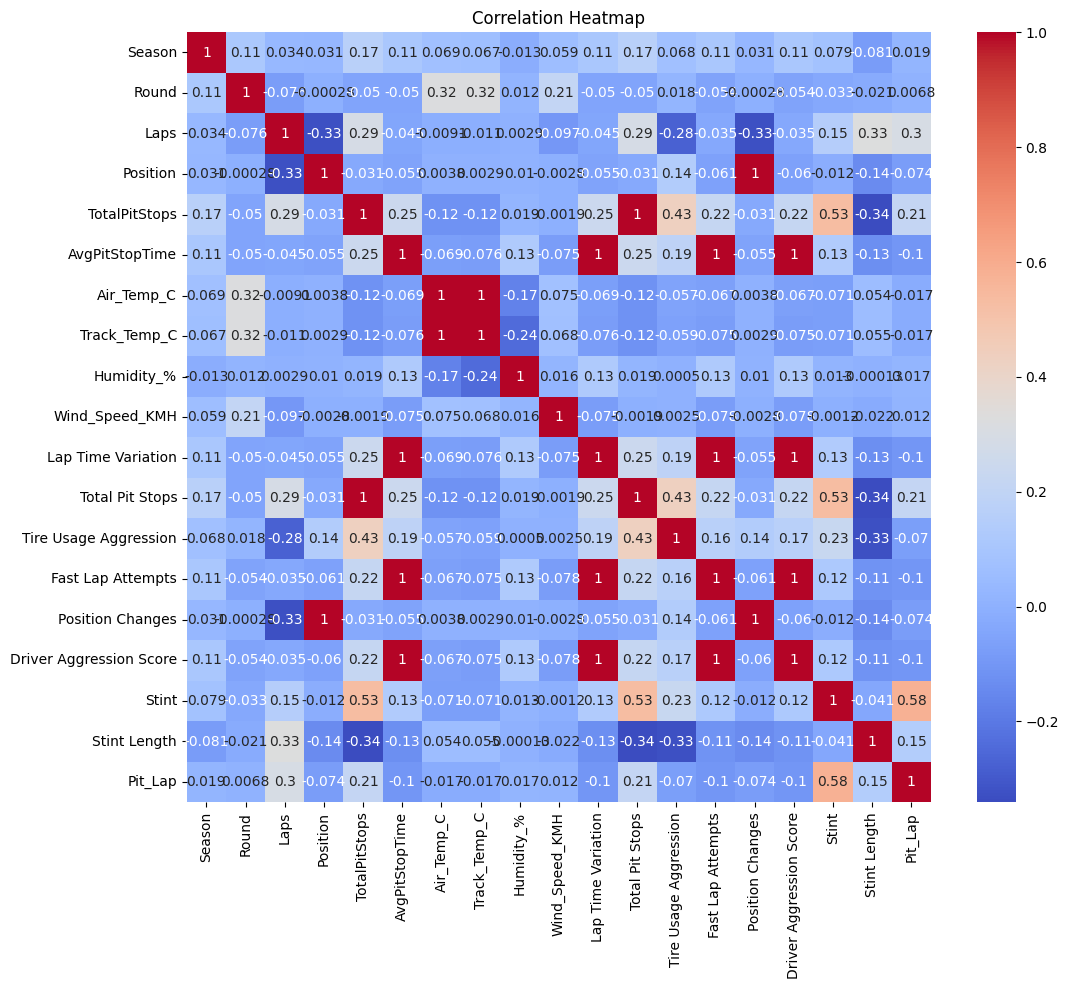

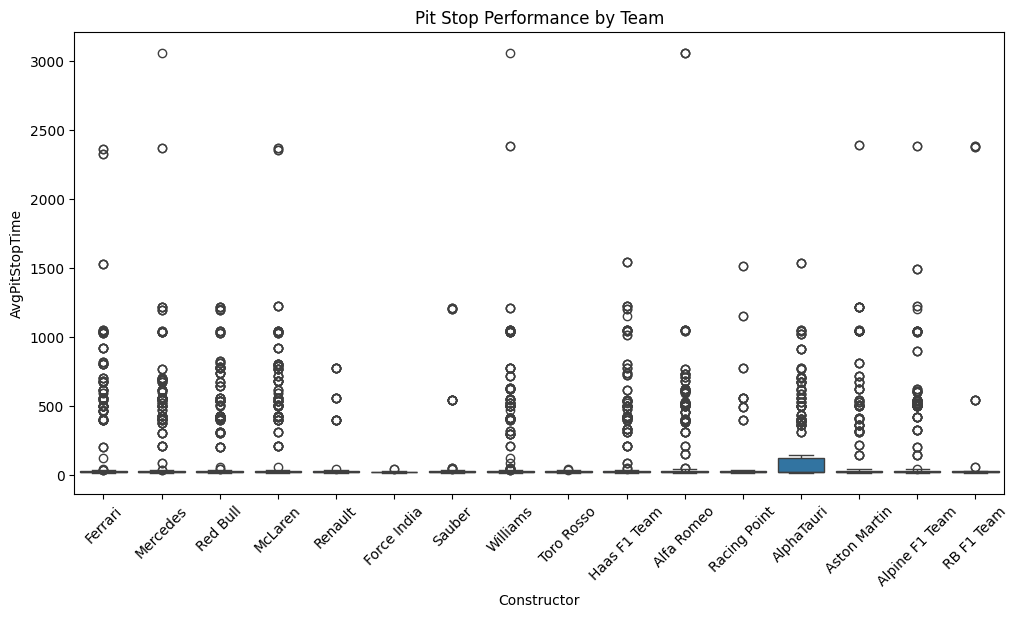

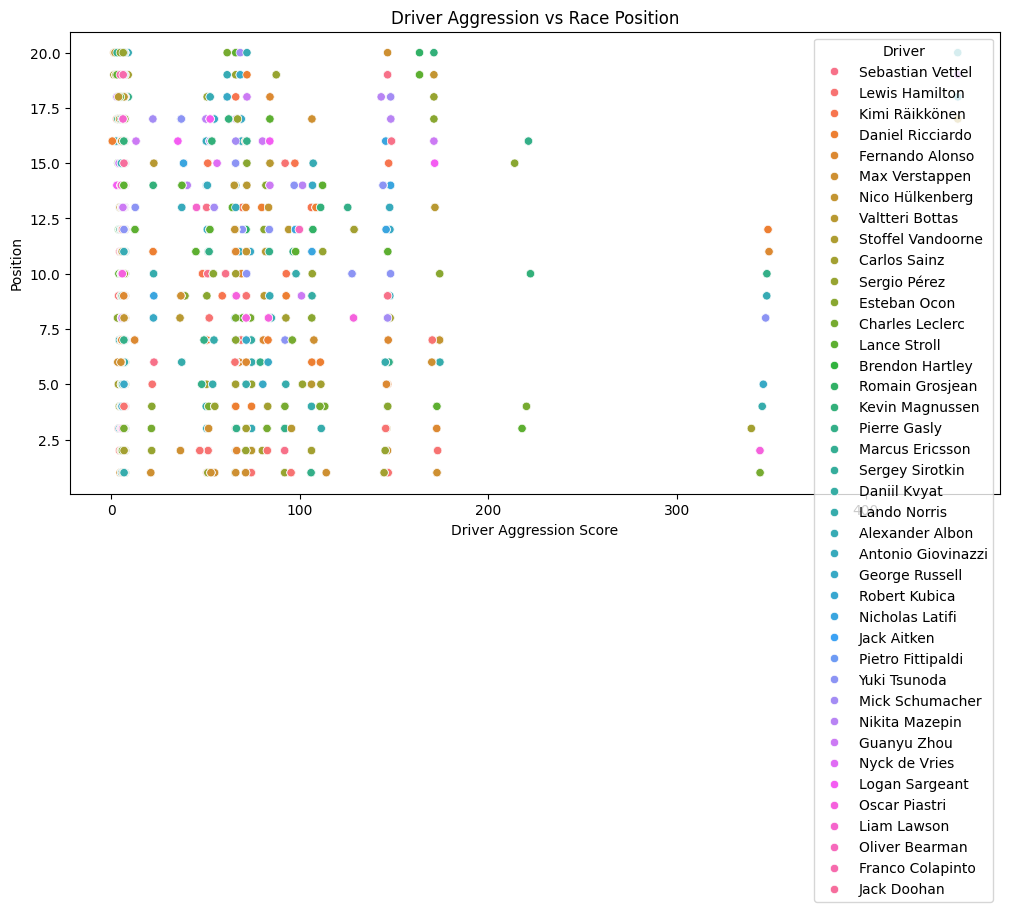

In [7]:
# Plot driver performance over years
plt.figure(figsize=(15, 8))
sns.lineplot(x='Year', y='Position', hue='Driver', data=df, estimator='mean', errorbar=None)
plt.title('Driver Performance Over Years')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Correlation heatmap
plt.figure(figsize=(12, 10))
corr = df.select_dtypes(include=['float64', 'int64']).corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

# Pit stop performance by constructor
plt.figure(figsize=(12, 6))
sns.boxplot(x='Constructor', y='AvgPitStopTime', data=df)
plt.xticks(rotation=45)
plt.title('Pit Stop Performance by Team')
plt.show()

# Driver aggression vs position
plt.figure(figsize=(12, 6))
sns.scatterplot(x='Driver Aggression Score', y='Position', hue='Driver', data=df)
plt.title('Driver Aggression vs Race Position')
plt.show()

Step 3: Preparing Data for Machine Learning

In [8]:
# Create target variable - champion is defined as finishing in top 3 positions consistently
df['Top3'] = df['Position'].apply(lambda x: 1 if x <= 3 else 0)

# Group by driver to get aggregate stats
driver_stats = df.groupby('Driver').agg({
    'Position': 'mean',
    'AvgPitStopTime': 'mean',
    'TotalPitStops': 'mean',
    'Driver Aggression Score': 'mean',
    'Lap Time Variation': 'mean',
    'Top3': 'sum',
    'Year': 'count'  # number of races participated
}).reset_index()

driver_stats.rename(columns={'Year': 'RacesParticipated'}, inplace=True)

# Calculate championship probability (target variable)
# We'll consider drivers who finished in top 3 in at least 30% of their races as potential champions
driver_stats['ChampionPotential'] = (driver_stats['Top3'] / driver_stats['RacesParticipated'] > 0.3).astype(int)

# Features and target
X = driver_stats[['Position', 'AvgPitStopTime', 'TotalPitStops', 'Driver Aggression Score', 'Lap Time Variation', 'RacesParticipated']]
y = driver_stats['ChampionPotential']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Step 4: Training Machine Learning Models


Logistic Regression:
Accuracy: 0.88
F1 Score: 0.00
Confusion Matrix:
[[7 0]
 [1 0]]


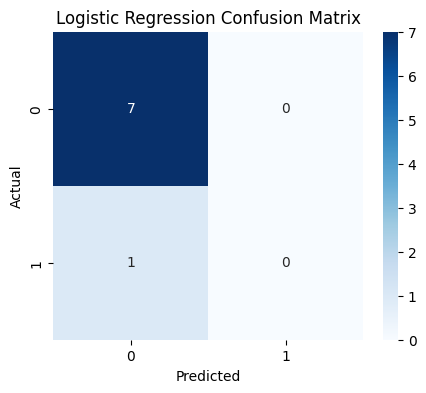


Random Forest:
Accuracy: 0.88
F1 Score: 0.00
Confusion Matrix:
[[7 0]
 [1 0]]


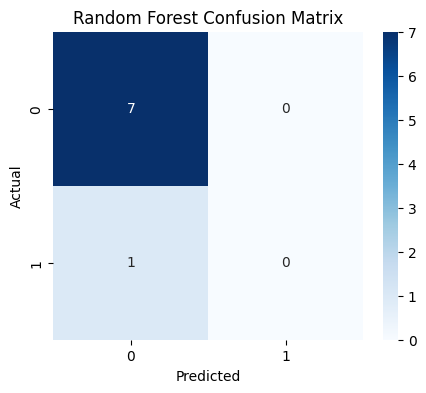


KNN:
Accuracy: 1.00
F1 Score: 1.00
Confusion Matrix:
[[7 0]
 [0 1]]


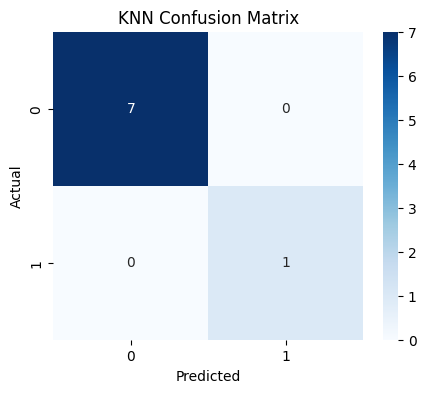


Naive Bayes:
Accuracy: 0.75
F1 Score: 0.00
Confusion Matrix:
[[6 1]
 [1 0]]


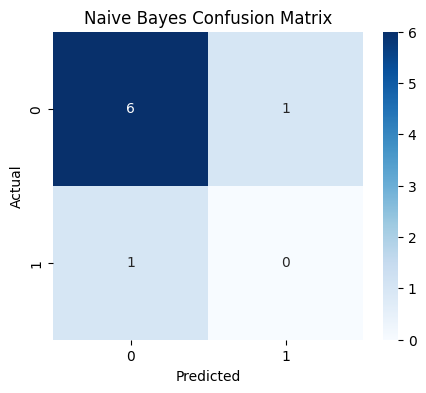

In [9]:
# Initialize models
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'KNN': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB()
}

# Train and evaluate models
results = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    results[name] = {
        'accuracy': accuracy,
        'f1_score': f1,
        'confusion_matrix': cm
    }

# Display results
for model_name, metrics in results.items():
    print(f"\n{model_name}:")
    print(f"Accuracy: {metrics['accuracy']:.2f}")
    print(f"F1 Score: {metrics['f1_score']:.2f}")
    print("Confusion Matrix:")
    print(metrics['confusion_matrix'])

    # Plot confusion matrix
    plt.figure(figsize=(5, 4))
    sns.heatmap(metrics['confusion_matrix'], annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

Step 5: Model Comparison and Selection

                     Accuracy  F1 Score
Model                                  
KNN                     1.000       1.0
Logistic Regression     0.875       0.0
Random Forest           0.875       0.0
Naive Bayes             0.750       0.0


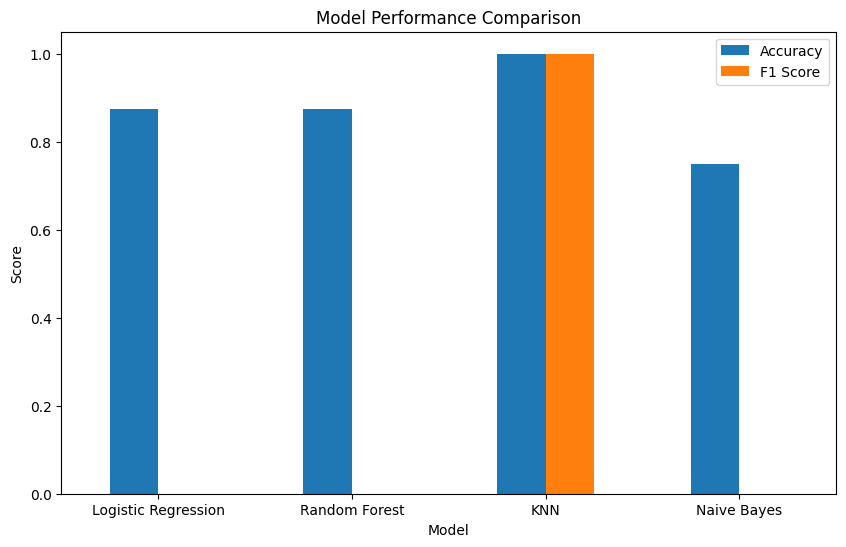

In [10]:
# Compare model performance
comparison = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [metrics['accuracy'] for metrics in results.values()],
    'F1 Score': [metrics['f1_score'] for metrics in results.values()]
}).set_index('Model')

print(comparison.sort_values('Accuracy', ascending=False))

# Visual comparison
comparison.plot(kind='bar', figsize=(10, 6))
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.show()

Step 6: Predicting the 2025 Champion

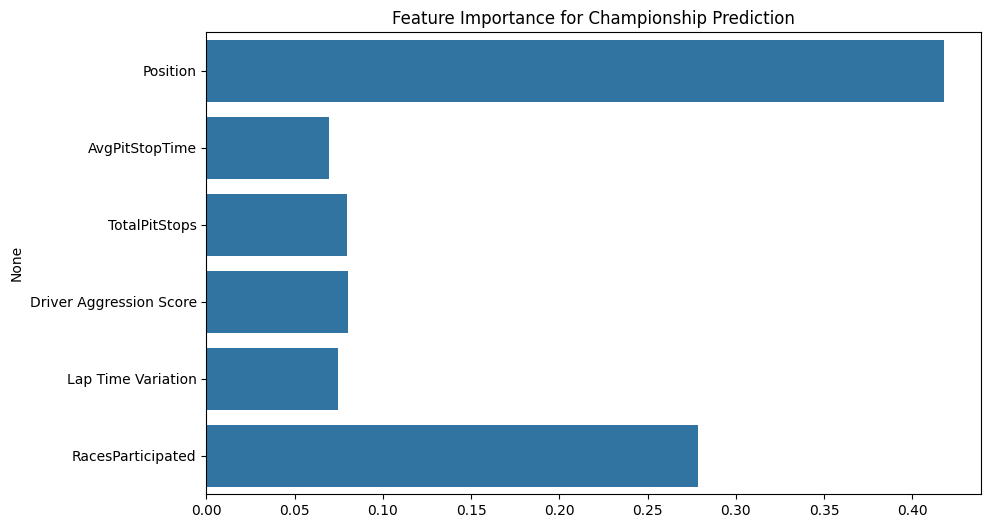

                Driver  ChampionProbability   Position  AvgPitStopTime  \
18      Lewis Hamilton                 0.81   4.242744      130.019745   
22      Max Verstappen                 0.75   3.703412      109.748817   
4      Charles Leclerc                 0.74   7.125683      110.462050   
38     Valtteri Bottas                 0.66   9.282258      127.585994   
30        Pierre Gasly                 0.17  10.948087      125.378069   
3         Carlos Sainz                 0.12   7.402266      133.518648   
36        Sergio Pérez                 0.08   8.057895      118.460794   
0      Alexander Albon                 0.04  11.509158      104.942356   
34    Sebastian Vettel                 0.04   8.910931      119.310252   
1   Antonio Giovinazzi                 0.03  13.743421      132.635557   

    Driver Aggression Score  
18                20.108948  
22                17.477196  
4                 17.796150  
38                19.703416  
30                19.526429  
3    

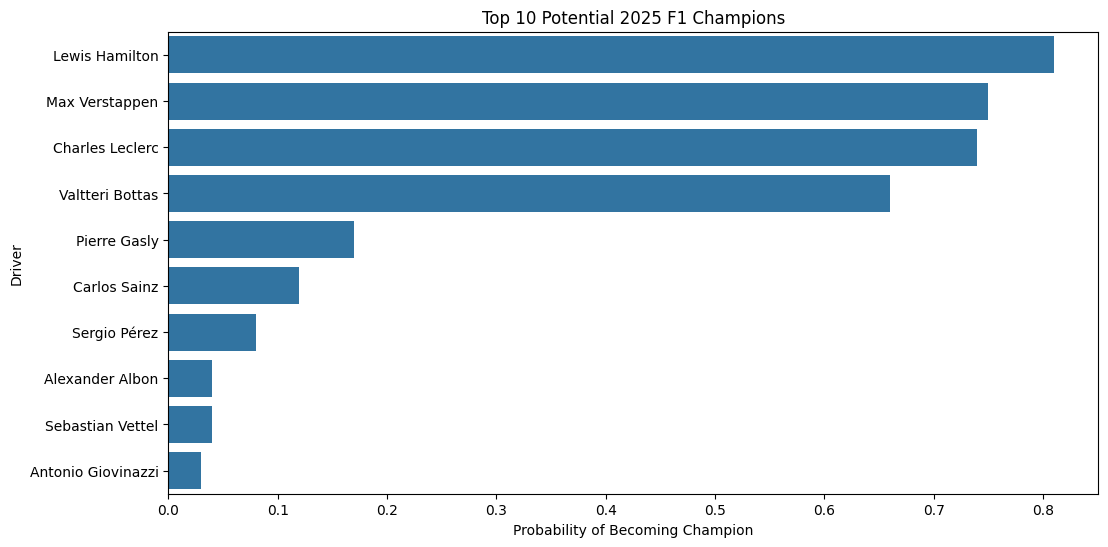

In [11]:
# Train final model on all data
final_model = RandomForestClassifier()
final_model.fit(scaler.fit_transform(X), y)

# Get feature importances
importances = final_model.feature_importances_
features = X.columns

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=features)
plt.title('Feature Importance for Championship Prediction')
plt.show()

# Predict probabilities for all drivers
driver_stats['ChampionProbability'] = final_model.predict_proba(scaler.transform(X))[:, 1]

# Display top potential champions
potential_champions = driver_stats.sort_values('ChampionProbability', ascending=False).head(10)
print(potential_champions[['Driver', 'ChampionProbability', 'Position', 'AvgPitStopTime', 'Driver Aggression Score']])

# Visualize top potential champions
plt.figure(figsize=(12, 6))
sns.barplot(x='ChampionProbability', y='Driver', data=potential_champions)
plt.title('Top 10 Potential 2025 F1 Champions')
plt.xlabel('Probability of Becoming Champion')
plt.show()